In [1]:
import jax
from jax import numpy as jnp, random as jr, value_and_grad, tree_util

import optax

import numpy as np
import matplotlib.pyplot as plt

from env import sample_data, plot_data
from svae.inference import make_gradfun
from svae.utils import split_into_batches
from svae.network import init_mlp, identity, make_loglike
from svae.models.hmm import run_inference, init_pgm_param, rollout, onehot_sample

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


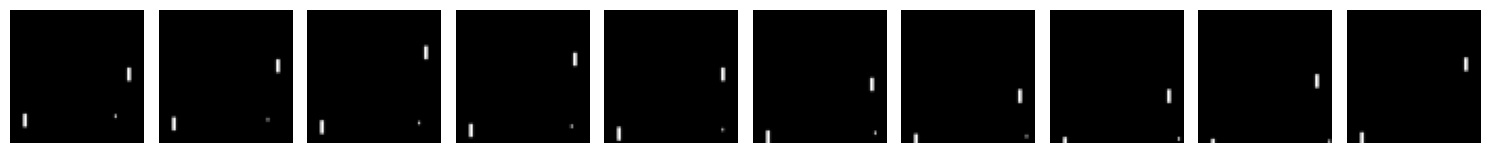

In [2]:
key = jr.PRNGKey(0)


batch_dim = 5
num_samples = 5
num_steps = 100
env = "ALE/Pong-v5"
crop_values = (34, 0, 194, 160)
resize_values = (64, 64)

data, actions = sample_data(env, num_samples, num_steps, crop_values, resize_values)

num_steps = 10
data = data[:, -num_steps:, :, :]
actions = actions[:, -num_steps:]

num_datapoints, num_steps, height, width = data.shape
D = height * width
plot_data(data[0])

data = jnp.array(data).reshape(num_datapoints, num_steps, D)
actions = jnp.array(actions).reshape(num_datapoints, num_steps)


batch_key, key = jr.split(key)
(data_batches, action_batches), num_batches = split_into_batches(batch_key, (data, actions), batch_dim)
get_batch = lambda i: data_batches[i % num_batches]
get_action_batch = lambda i: action_batches[i % num_batches]

In [3]:
def infer_images(params, prior_params, data, actions, key):
    infer_key, key = jr.split(key)
    pgm_params, decoder_params, encoder_params = params
    node_potentials = encoder(encoder_params, data)
    samples, _, _, _ = run_inference(infer_key, prior_params, pgm_params, node_potentials, 1, actions)
    return decoder(decoder_params, samples)


def test(params, prior_params, data, actions, env, key):
    idx = np.random.randint(data.shape[0])
    test_data = data[idx : idx + 1, :]
    test_actions = actions[idx : idx + 1, :]
    decoded = infer_images(params, prior_params, test_data, test_actions, key)

    plot_data(test_data.reshape(-1, 64, 64))
    plot_data(decoded.reshape(-1, 64, 64))

epoch 0: 2839.37


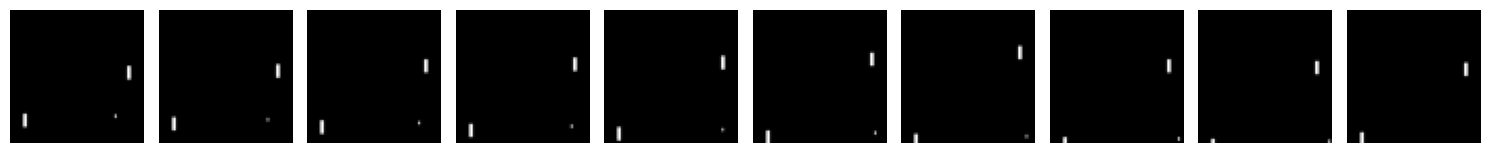

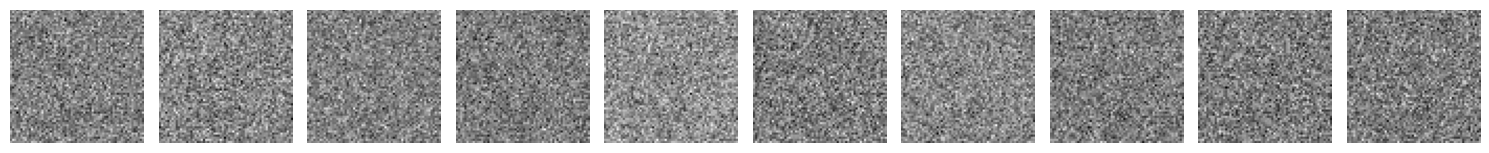

epoch 200: 52.01


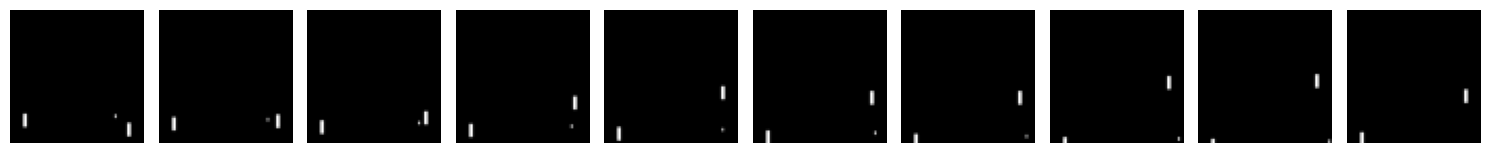

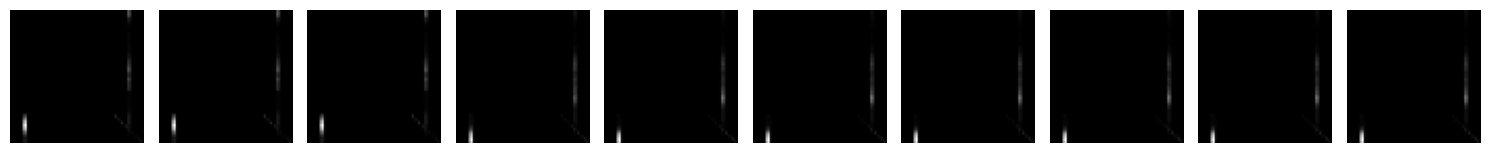

epoch 400: 41.49


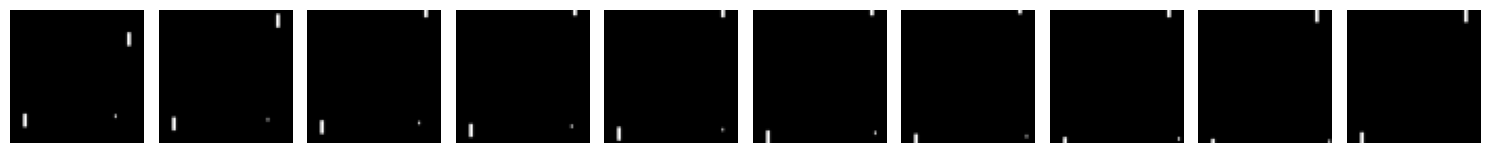

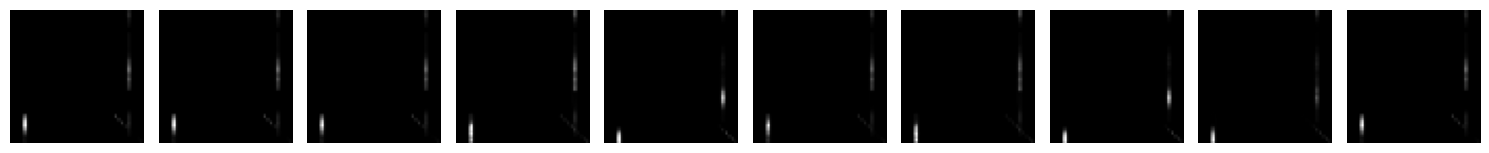

epoch 600: 14.71


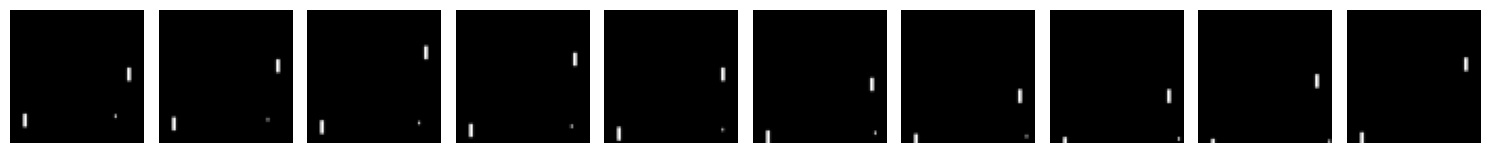

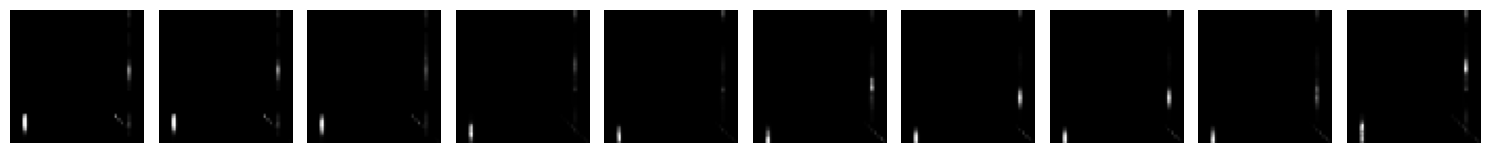

epoch 800: -14.91


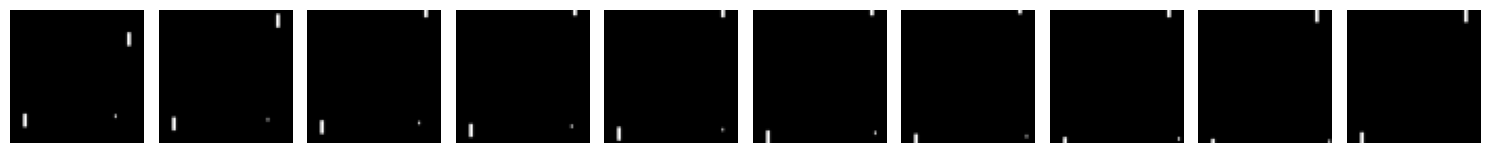

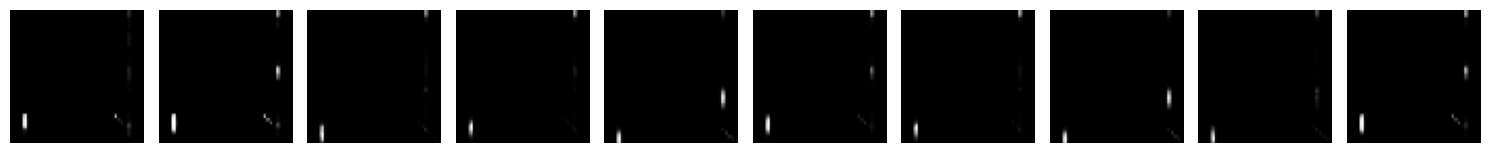

epoch 1000: -38.16


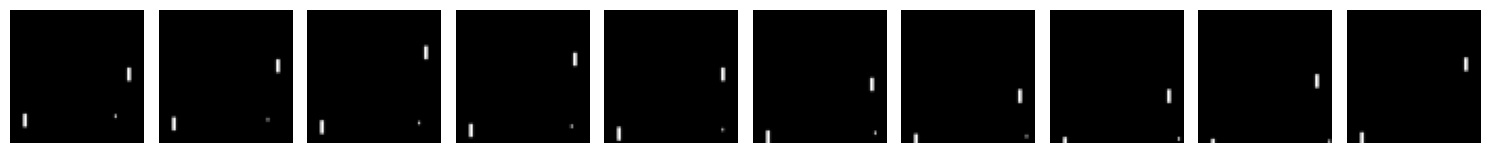

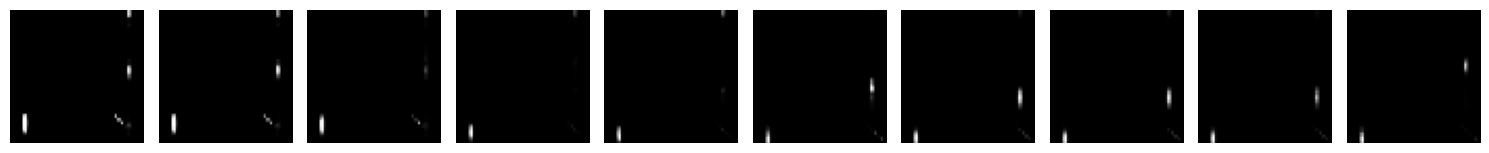

epoch 1200: -59.43


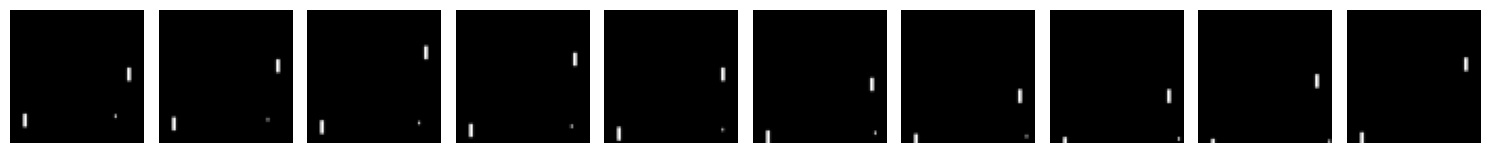

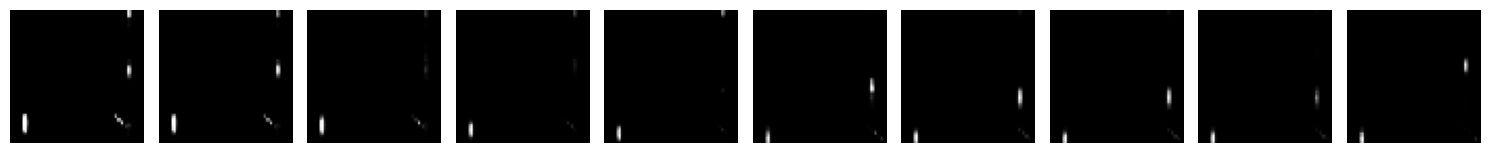

epoch 1400: -79.93


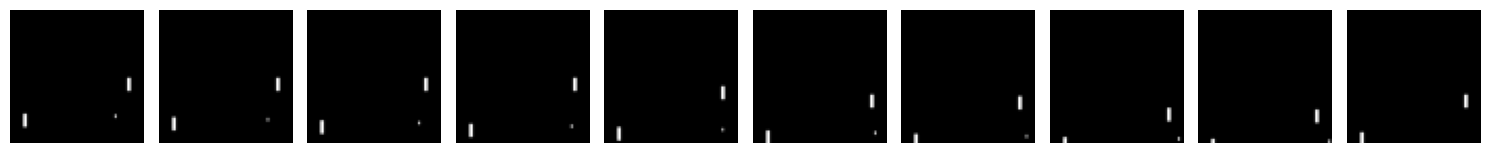

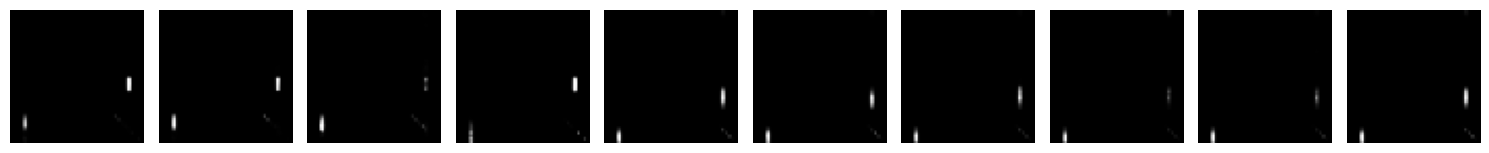

epoch 1600: -100.10


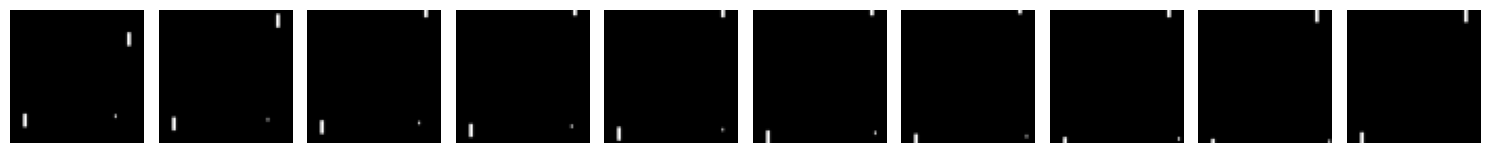

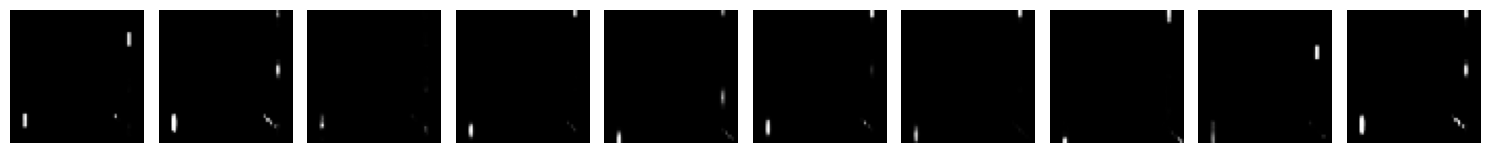

epoch 1800: -121.21


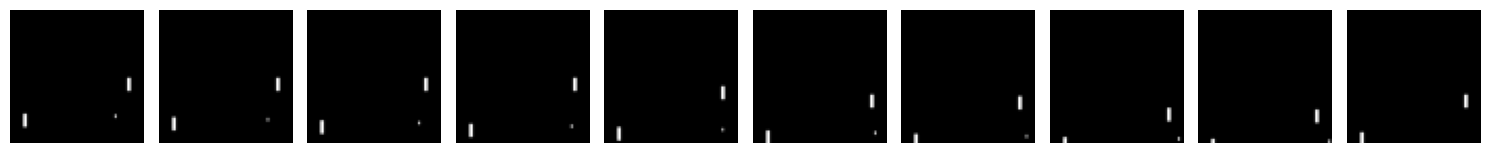

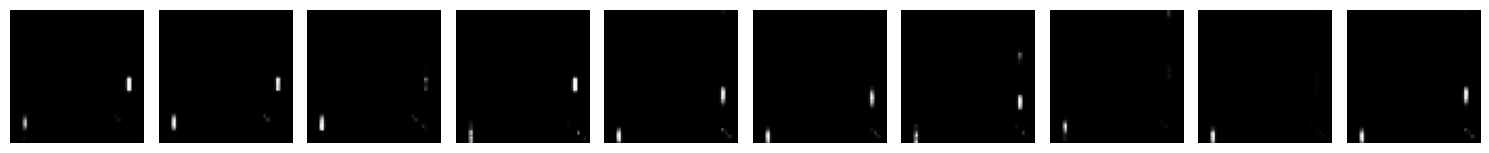

epoch 2000: -141.31


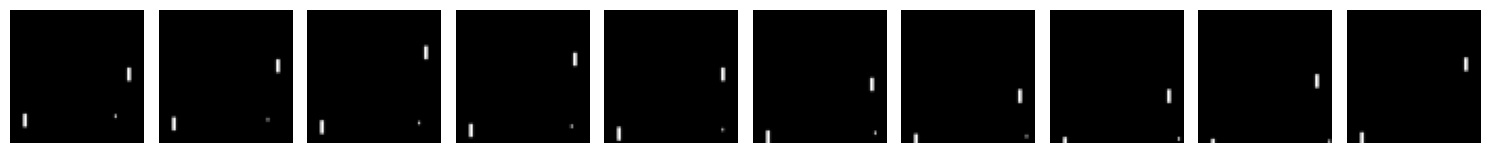

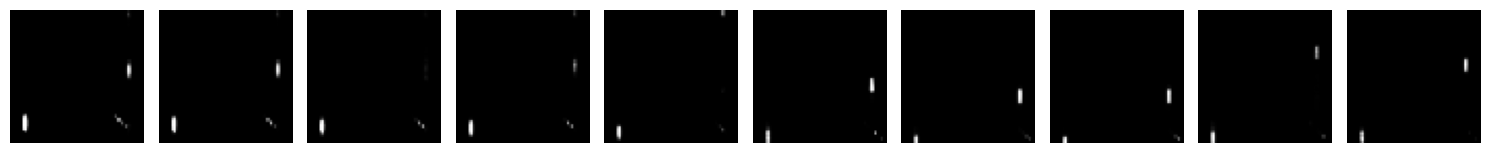

epoch 2200: -154.76


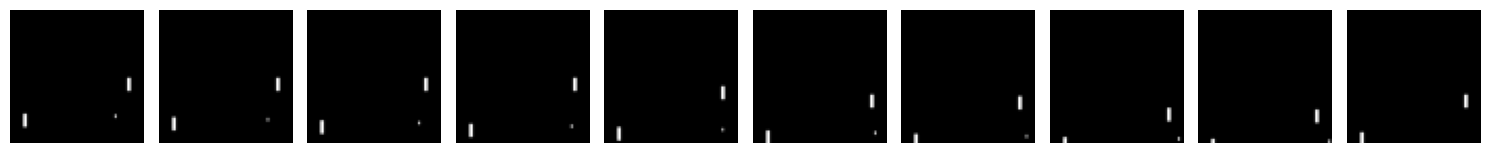

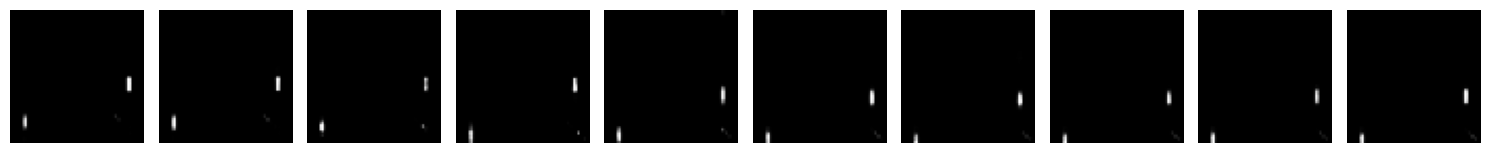

In [4]:
num_epochs = 6000
A, K = 6, 100

prior_key, key = jr.split(key)
pgm_prior_params = init_pgm_param(prior_key, K, A, alpha=1.0)

encoder_key, key = jr.split(key)
encoder, encoder_params = init_mlp(encoder_key, D, [(512, jax.nn.relu), (K, identity)])

decoder_key, key = jr.split(key)
decoder, decoder_params = init_mlp(decoder_key, K, [(512, jax.nn.relu), (D, jax.nn.sigmoid)])
loglike = make_loglike(decoder)

pgm_key, key = jr.split(key)
pgm_params = init_pgm_param(pgm_key, K, A, alpha=1.0)

schedule = optax.linear_schedule(
    init_value=1e-3,
    end_value=1e-5,
    transition_steps=num_epochs,
)
pgm_optim = optax.sgd(learning_rate=1e-3)
nn_optim = optax.adamw(schedule)

pgm_opt_state = pgm_optim.init(pgm_params)
nn_opt_state = nn_optim.init((decoder_params, encoder_params))

grad_key, key = jr.split(key)
gradfun = make_gradfun(
    grad_key, run_inference, encoder, loglike, pgm_prior_params, 1, num_datapoints * num_steps, num_batches, 1e4
)

for epoch in range(num_epochs):
    (pgm_grads, decoder_grads, encoder_grads), elbo = gradfun(
        (pgm_params, decoder_params, encoder_params), get_batch(epoch), get_action_batch(epoch)
    )

    pgm_updates, pgm_opt_state = pgm_optim.update(pgm_grads, pgm_opt_state, pgm_params)
    nn_updates, nn_opt_state = nn_optim.update(
        (decoder_grads, encoder_grads), nn_opt_state, (decoder_params, encoder_params)
    )

    pgm_params = optax.apply_updates(pgm_params, pgm_updates)
    (decoder_params, encoder_params) = optax.apply_updates((decoder_params, encoder_params), nn_updates)

    if epoch % 200 == 0:
        print(f"epoch {epoch}: {elbo:.2f}")
        test((pgm_params, decoder_params, encoder_params), pgm_prior_params, data, actions, env, key)